In [2]:
import os
import sys 
import json
import glob
import random
import collections
import time
import re

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import matplotlib.pyplot as plt
from matplotlib import animation, rc
rc('animation', html='jshtml')
import seaborn as sns

data_directory = '../data'

In [1]:
def load_dicom_image(path, img_size=256, voi_lut=True, rotate=0):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    if rotate > 0:
        rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        data = cv2.rotate(data, rot_choices[rotate])
        
    data = cv2.resize(data, (img_size, img_size))
    return data


def load_dicom_images_3d(scan_id, num_imgs=32, img_size=256, mri_type="FLAIR", split="train", rotate=0):

    files = sorted(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

    middle = len(files)//2
    num_imgs2 = num_imgs//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    for i, f in enumerate(files):
        frame = load_dicom_image(f, rotate=rotate)
        if frame.std() > 10:
            files = files[i:]
            break
    for i, f in enumerate(files[::-1]):
        frame = load_dicom_image(f, rotate=rotate)
        if frame.std() > 10:
            files = files[:-1]
            break
    img3d = np.stack([load_dicom_image(f, rotate=rotate) for f in files[::max(1, int(len(files)/num_imgs))][:num_imgs]])
#     for i, frame in enumerate(img3d):
#         if np.min(frame) < np.max(frame):
#             img3d[i] = frame - np.min(frame)
#             img3d[i] = frame / np.max(frame)
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)
    if img3d.shape[0] < num_imgs:
        n_zero = np.zeros((num_imgs - img3d.shape[0], img_size, img_size))
        img3d = np.concatenate((img3d,  n_zero), axis = 0)
#     print(img3d.shape)
    
            
    return img3d

In [644]:
img = load_dicom_images_3d("00124")


In [645]:
img.mean()

0.06739255336546718

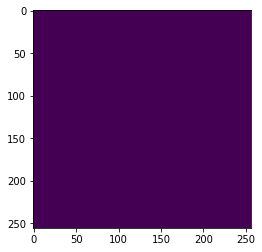

In [646]:
plt.imshow(img[31])

In [647]:
def create_animation(ims):
    fig = plt.figure(figsize=(6, 6))
    plt.axis('off')
    im = plt.imshow(ims[0], cmap="gray")

    def animate_func(i):
        im.set_array(ims[i])
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames = len(ims), interval = 1000//24)

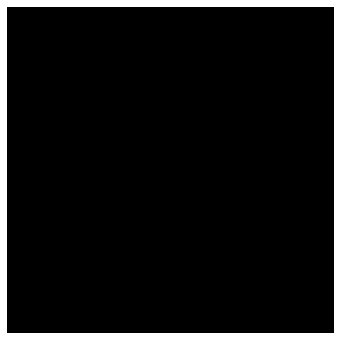

In [648]:
create_animation(img)

In [630]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter("test.avi", fourcc, 10, (img.shape[1], img.shape[2]), 0)

In [635]:
print(img.mean())
for frame in img:
    res = out.write((frame*255).astype(np.uint8))

4931.7346101879975


In [632]:
out.release()

In [633]:
cap = cv2.VideoCapture("test.avi")
new_imgs = []
while(cap.isOpened()):
    ret, frame = cap.read()   
    if ret == True:
        frame = frame[:,:,0]
        new_imgs.append(frame)
    else: 
        break

# When everything done, release the video capture object
cap.release()

In [ ]:
create_animation(new_imgs)

In [4]:
annotation = pd.read_csv(os.path.join(data_directory, 'train_labels.csv'))
train_annotation, val_annotation = train_test_split(
    annotation, 
    test_size=0.2, 
    random_state=12, 
    stratify=annotation["MGMT_value"],
)
annotation = dict(zip(annotation.BraTS21ID, annotation.MGMT_value))
print(annotation)

{0: 1, 2: 1, 3: 0, 5: 1, 6: 1, 8: 1, 9: 0, 11: 1, 12: 1, 14: 1, 17: 0, 18: 0, 19: 0, 20: 1, 21: 0, 22: 0, 24: 0, 25: 1, 26: 1, 28: 1, 30: 0, 31: 1, 32: 0, 33: 1, 35: 1, 36: 0, 43: 1, 44: 0, 45: 0, 46: 1, 48: 1, 49: 0, 52: 1, 53: 0, 54: 1, 56: 1, 58: 1, 59: 1, 60: 1, 61: 0, 62: 1, 63: 1, 64: 0, 66: 1, 68: 1, 70: 1, 71: 1, 72: 0, 74: 1, 77: 1, 78: 1, 81: 0, 84: 0, 85: 1, 87: 1, 88: 0, 89: 1, 90: 0, 94: 1, 95: 0, 96: 1, 97: 0, 98: 1, 99: 0, 100: 1, 102: 0, 104: 0, 105: 1, 106: 1, 107: 1, 108: 0, 109: 1, 110: 0, 111: 0, 112: 0, 113: 0, 116: 0, 117: 1, 120: 1, 121: 0, 122: 0, 123: 0, 124: 0, 128: 1, 130: 0, 132: 0, 133: 0, 134: 1, 136: 1, 137: 0, 138: 1, 139: 1, 140: 1, 142: 0, 143: 1, 144: 1, 146: 1, 147: 0, 148: 0, 149: 0, 150: 0, 151: 0, 154: 0, 155: 1, 156: 1, 157: 0, 158: 0, 159: 1, 160: 1, 162: 0, 165: 0, 166: 1, 167: 0, 169: 0, 170: 0, 171: 1, 172: 0, 176: 0, 177: 1, 178: 1, 183: 0, 184: 0, 185: 1, 186: 1, 187: 1, 188: 1, 191: 0, 192: 0, 193: 0, 194: 0, 195: 0, 196: 1, 197: 1, 199: 1

In [654]:
train_annotation.tail()

,BraTS21ID,MGMT_value
105,157,0
222,322,1
114,170,0
223,324,0
81,123,0


In [6]:
output_path = '../data_videos'
for mode in ['train']:
    for mri_type in ["FLAIR", "T1w", "T1wCE", "T2w"]:
        train_annots = []
        val_annots = []
        os.makedirs(os.path.join(output_path, mode, mri_type), exist_ok=True)
#         with open(os.path.join(output_path, f'{mri_type}_annotation.txt'), 'w') as f:
        if True:
            for sample in os.listdir(os.path.join(data_directory, mode)):
                print(sample)
                annotation_sample = os.path.join(mode, mri_type, f'{sample}.avi') + ' ' + str(annotation[int(sample)]) + '\n'
                if int(sample) in val_annotation['BraTS21ID'].to_list():
                    print(sample)
                    val_annots.append(annotation_sample)
                else:
                    train_annots.append(annotation_sample)
                    
                imgs = load_dicom_images_3d(sample, mri_type=mri_type, split=mode)
                fourcc = cv2.VideoWriter_fourcc(*'XVID')
                out = cv2.VideoWriter(os.path.join(output_path, mode, mri_type, f"{sample}.avi"), fourcc, 10, (imgs.shape[1], imgs.shape[2]), 0)
                for frame in imgs:
                    res = out.write((frame*255).astype(np.uint8))
                out.release()
#                 f.write(annotation_sample)
#         with open(os.path.join(output_path, f'{mri_type}_train_annotation.txt'), 'w') as f:  
#             f.writelines(train_annots)
#         with open(os.path.join(output_path, f'{mri_type}_val_annotation.txt'), 'w') as f:  
#             f.writelines(val_annots)

00485
00485
00642
00291
00087
00087
00655
00258
00472
00758
00231
00077
00622
00120
00667
00469
00379
00284
00284
00124
00043
00322
00008
00839
00138
00138
00316
00729
00727
00727
00791
00641
00166
00402
00757
00199
00823
00586
00110
00212
00212
00149
00149
00133
00774
00084
00296
00830
00314
00314
00436
00552
00360
00360
00169
00169
00105
00386
00780
00389
00063
00165
00794
00220
00288
00645
00247
00206
00206
00494
00584
00378
00704
00331
00253
00253
00651
00651
00376
00459
00737
00397
00045
00392
00098
00803
00122
00024
00191
00346
00616
00210
00009
00788
00788
00416
00559
00176
00176
00618
00649
00543
00543
00555
00568
00736
01001
00128
01005
00369
00347
00254
00377
00377
00661
00391
00320
00725
00725
00167
00442
00413
00440
00999
00623
00623
00621
00802
00802
00481
00481
00310
00289
00289
00620
00759
00192
00192
00251
00775
00290
00106
00106
00807
00283
00744
00104
00516
00095
00203
00578
00578
00303
00714
00706
00432
00581
00478
00513
00513
00808
00808
00697
00594
00209
00157
0030

00090
00262
00495
00352
00998
00197
00053
00747
00211
00263
00801
00668
00025
00269
00510
00510
01002
00356
00572
00811
00811
00089
00425
00425
00520
00414
00583
00591
00692
00186
00178
00241
00806
00806
00781
00742
00742
00539
00485
00485
00642
00291
00087
00087
00655
00258
00472
00758
00231
00077
00622
00120
00667
00469
00379
00284
00284
00124
00043
00322
00008
00839
00138
00138
00316
00729
00727
00727
00791
00641
00166
00402
00757
00199
00823
00586
00110
00212
00212
00149
00149
00133
00774
00084
00296
00830
00314
00314
00436
00552
00360
00360
00169
00169
00105
00386
00780
00389
00063
00165
00794
00220
00288
00645
00247
00206
00206
00494
00584
00378
00704
00331
00253
00253
00651
00651
00376
00459
00737
00397
00045
00392
00098
00803
00122
00024
00191
00346
00616
00210
00009
00788
00788
00416
00559
00176
00176
00618
00649
00543
00543
00555
00568
00736
01001
00128
01005
00369
00347
00254
00377
00377
00661
00391
00320
00725
00725
00167
00442
00413
00440
00999
00623
00623
00621
00802
0080

00565
00557
00297
00148
00836
00406
00507
00222
00222
00782
00782
00111
00804
00795
00068
00064
00250
00810
00619
00188
00525
00525
00709
00789
00052
00072
00430
00026
00349
00195
00753
00816
00570
00000
00501
00329
00470
00090
00262
00495
00352
00998
00197
00053
00747
00211
00263
00801
00668
00025
00269
00510
00510
01002
00356
00572
00811
00811
00089
00425
00425
00520
00414
00583
00591
00692
00186
00178
00241
00806
00806
00781
00742
00742
00539


In [10]:
train_annotation['MGMT_value'].mean()

0.5256410256410257

In [13]:
from sklearn.metrics import roc_auc_score
y = [1,0,1,1,1]
y = [1-t for t in y]
y_pred = [0.4,0.4,0.7,0.9,0.85]
roc_auc_score(y,y_pred)

0.125

In [24]:
import pickle
from sklearn.metrics import roc_auc_score

In [21]:
with open('flair.pkl','rb') as f:
    flair = np.array(pickle.load(f))
with open('t1w.pkl','rb') as f:
    t1w = np.array(pickle.load(f))
with open('t1wce.pkl','rb') as f:
    t1wce = np.array(pickle.load(f))
with open('t2w.pkl','rb') as f:
    t2w = np.array(pickle.load(f))

In [25]:
gt = [1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0]
roc_auc_score(gt, (flair+t1w+t1wce+t2w)/4)

0.6033372365339578